# Enriquecimiento Climático y Refinamiento del Modelo (ML)

**Proyecto:** NavOptima - Optimización de Eficiencia Energética Naval  
**Fase:** Data Fusion (ERA5) y Validación de Resistencia Añadida

---

**Objetivo del Módulo**

Integrar variables meteorológicas reales (**Dataset ERA5 de Copernicus**) al dataset curado de AIS para cuantificar la "Resistencia Añadida" por viento y oleaje. Validaremos si la inclusión de factores climáticos reduce el error del modelo (RMSE) en comparación con el baseline puramente físico.

**Contexto Técnico (Refinamiento DS)**

A las limitaciones detectadas en el EDA, sumamos el factor ambiental:
1.  **Resistencia Añadida:** El consumo no solo depende de la velocidad ($V^3$), sino del esfuerzo extra para vencer el viento de proa y la energía de las olas ($SWH^2$).
2.  **Data Fusion Espacio-Temporal:** Utilizaremos las "anclas" (`timestamp`, `latitude`, `longitude`) para realizar un join preciso con la malla climática de Copernicus.
3.  **Interacción No-Lineal:** El clima afecta de forma diferente según el calado (`draft`) y el tamaño del buque (`length`). Los modelos de ensamble (XGBoost) deberán capturar estas interacciones.

**Estrategia de Validación (Rules of Engagement)**

Para garantizar que el modelo sea auditable y generalizable:
* **Split Cronológico Estricto:** Entrenaremos con datos históricos y evaluaremos con el "futuro" del dataset para simular una operación real.
* **Aislamiento de Features:** Compararemos el rendimiento del modelo "Ciego al Clima" vs "Sensible al Clima".
* **Métrica Decisiva:** RMSE (Root Mean Squared Error) y R².

---

**Modelos a Evaluar**

1.  **Baseline:** Regresión Lineal (OLS) con variables climáticas base.
2.  **Retador 1:** Random Forest - Captura de interacciones complejas viento/olas.
3.  **Retador 2:** XGBoost Regressor - Optimizado para el volumen de datos de telemetría.

## Instalacion librerias y configuracion de Entorno

### Librerias

#### Deteccion ubicacion de entorno virtual

In [2]:
import sys
print(sys.executable)

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import xarray as xr      # Fundamental para manejar los cubos de datos .nc
import netCDF4           # Motor de lectura para archivos NetCDF
import cdsapi            # API oficial de Copernicus
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# --- VERIFICACIÓN DE ENTORNO ---
print(f"🐍 Python Executable: {sys.executable}")
print(f"📂 Directorio Actual: {os.getcwd()}")

🐍 Python Executable: ...📂 Directorio Actual: ..

### Configuración de Rutas y Carga de Datos "Ancla"

In [4]:

# Definición de rutas relativas (Estilo profesional)
# Como el notebook está en /notebooks, subimos un nivel para ir a /data
BASE_DIR = Path("..")
DATA_PATH = BASE_DIR / "data" / "curated" / "df_clean_ais.csv"

# Carga del dataset con las "anclas" (Lat, Lon, Timestamp)
# parse_dates convierte el texto del tiempo en objetos que Python entiende
try:
    df_ais = pd.read_csv(DATA_PATH, parse_dates=['timestamp'])
    print(f"✅ Dataset cargado exitosamente desde: {DATA_PATH}")
    print(f"📊 Total de registros: {len(df_ais):,}")
    
    # Verificamos que las columnas necesarias existan
    required_cols = ['timestamp', 'latitude', 'longitude']
    missing = [c for c in required_cols if c not in df_ais.columns]
    
    if not missing:
        print("📍 Anclas espacio-temporales detectadas correctamente.")
    else:
        print(f"❌ Error: Faltan las columnas {missing}")

except FileNotFoundError:
    print(f"❌ Error: No se encontró el archivo en {DATA_PATH}. Verifica la ruta.")

# Mostramos los primeros datos para estar seguros
df_ais.head()

✅ Dataset cargado exitosamente desde: ../data/curated/df_clean_ais.csv
📊 Total de registros: 2,421,675
📍 Anclas espacio-temporales detectadas correctamente.


,timestamp,mmsi,latitude,longitude,sog,draft,length,fuel_consumption,log_fuel_consumption
0,2025-02-27 03:13:06,209535000,55.676678,12.635543,1.1,3.9,90.0,0.005191,0.005177
1,2025-02-27 03:13:06,209535000,55.676678,12.635543,1.1,3.9,90.0,0.005191,0.005177
2,2025-02-27 03:13:15,209535000,55.676730,12.635602,1.3,3.9,90.0,0.008568,0.008532
3,2025-02-27 03:13:25,209535000,55.676800,12.635683,1.5,3.9,90.0,0.013163,0.013077
4,2025-02-27 03:13:32,209535000,55.676800,12.635683,1.5,3.9,90.0,0.013163,0.013077


## Bounding Box: Definición del Área de Interés 

### Definicion de limites espacio-Temporales

In [5]:
# 1. Se determina los límites geográficos del dataset AIS
# Extraemos los valores extremos de latitud y longitud para acotar la búsqueda.
lat_min, lat_max = df_ais['latitude'].min(), df_ais['latitude'].max()
lon_min, lon_max = df_ais['longitude'].min(), df_ais['longitude'].max()

# 2. Se define un margen de seguridad (Padding)
# Aplicamos un offset de 0.25 grados para evitar pérdida de datos en los bordes.
padding = 0.25
north, south = lat_max + padding, lat_min - padding
west, east = lon_min - padding, lon_max + padding

# 3. Se captura el rango temporal del proyecto
# Convertimos el inicio y fin a formato string compatible con la API de Copernicus.
start_date = df_ais['timestamp'].min().strftime('%Y-%m-%d')
end_date = df_ais['timestamp'].max().strftime('%Y-%m-%d')

# 4. Se consolida el área de petición (Bounding Box)
# El formato requerido por ERA5 es: [Norte, Oeste, Sur, Este].
area_request = [north, west, south, east]

# 5. Salida de control para auditoría de datos
print("🛰️ PARÁMETROS DE CONSULTA GENERADOS:")
print(f"   > Cobertura Norte-Sur: {north:.2f} a {south:.2f}")
print(f"   > Cobertura Oeste-Este: {west:.2f} a {east:.2f}")
print(f"   > Ventana de Tiempo: {start_date} hasta {end_date}")

🛰️ PARÁMETROS DE CONSULTA GENERADOS:
   > Cobertura Norte-Sur: 59.11 a -29.69
   > Cobertura Oeste-Este: -44.79 a 44.11
   > Ventana de Tiempo: 2025-02-27 hasta 2025-02-27


#### Saneamiento Geográfico (Geo-Sanity Check)

**Justificación Técnica:**
Antes de ejecutar la extracción de datos climáticos de Copernicus (ERA5), es imperativo realizar una auditoría de integridad espacial. El análisis preliminar detectó **anomalías en la telemetría GPS** (coordenadas fuera del Mar del Norte/Báltico), lo cual es común en datos AIS crudos debido a errores de transmisión.

Aplicamos este filtrado restrictivo por dos razones críticas:

1. **Eficiencia de Ingesta:** Un Bounding Box contaminado por outliers (ej. latitud -29) obligaría a descargar petabytes de datos meteorológicos del Océano Atlántico innecesariamente.

2. **Calidad del Modelo:** Garantizamos que el algoritmo de ML aprenda exclusivamente de la interacción física real en la zona de operación (Dinamarca), eliminando ruido que degradaría el RMSE.

##### Diagnostico de outliers geograficos

Iniciando auditoría de coordenadas...
           latitude     longitude
count  2.421675e+06  2.421675e+06
mean   5.596057e+01  1.096917e+01
std    1.102612e+00  1.947596e+00
min   -2.943977e+01 -4.454171e+01
25%    5.501647e+01  1.004180e+01
50%    5.571718e+01  1.101996e+01
75%    5.682983e+01  1.186640e+01
max    5.885965e+01  4.386154e+01


...: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


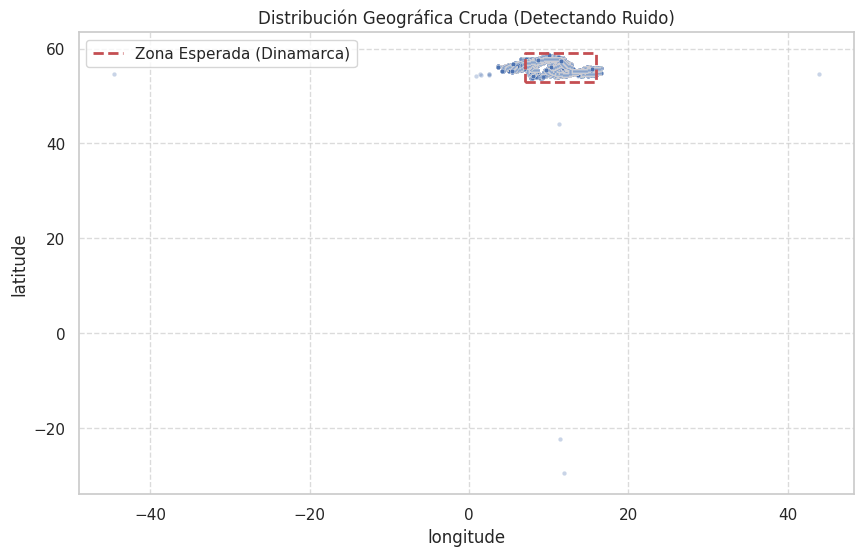

⚠️ Si ves puntos fuera del recuadro rojo, esos son los datos que debemos eliminar.


In [6]:
print("Iniciando auditoría de coordenadas...")

# 1. Estadística descriptiva rápida
print(df_ais[['latitude', 'longitude']].describe())

# 2. Visualización del error (Scatter Plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_ais, x='longitude', y='latitude', alpha=0.3, s=10)
plt.title('Distribución Geográfica Cruda (Detectando Ruido)')
plt.grid(True, linestyle='--', alpha=0.7)

# Dibujamos una caja roja donde DEBERÍA estar Dinamarca aprox.
# Lat: 53 a 59, Lon: 7 a 16
plt.plot([7, 16, 16, 7, 7], [53, 53, 59, 59, 53], 'r--', linewidth=2, label='Zona Esperada (Dinamarca)')
plt.legend()
plt.show()

print("⚠️ Si ves puntos fuera del recuadro rojo, esos son los datos que debemos eliminar.")

##### Data Cleansing: Limpieza y filtrado de datos 

In [7]:
# Definimos límites lógicos para la zona de operación (Mar del Norte / Báltico)
# Dinamarca está aprox entre Lat 54-58 y Lon 8-15. Damos un margen.
VALID_LAT_MIN = 53.0
VALID_LAT_MAX = 60.0
VALID_LON_MIN = 7.0
VALID_LON_MAX = 17.0

# Contamos antes de borrar
total_pre = len(df_ais)

# Aplicamos el filtro (Mantenemos solo lo que está DENTRO de la caja válida)
df_ais_clean = df_ais[
    (df_ais['latitude'] >= VALID_LAT_MIN) & 
    (df_ais['latitude'] <= VALID_LAT_MAX) & 
    (df_ais['longitude'] >= VALID_LON_MIN) & 
    (df_ais['longitude'] <= VALID_LON_MAX)
].copy()

# Reporte de limpieza
total_post = len(df_ais_clean)
deleted = total_pre - total_post

print(f"🧹 Limpieza completada.")
print(f"   - Registros originales: {total_pre:,}")
print(f"   - Registros válidos:    {total_post:,}")
print(f"   - Basura eliminada:     {deleted:,} ({(deleted/total_pre)*100:.2f}%)")

# Sobrescribimos el dataframe principal para seguir trabajando con los datos limpios
df_ais = df_ais_clean

🧹 Limpieza completada.
   - Registros originales: 2,421,675
   - Registros válidos:    2,384,020
   - Basura eliminada:     37,655 (1.55%)


##### Nuevos limites reales 

In [9]:
# Recalculamos min/max sobre los datos limpios
north = df_ais['latitude'].max() + 0.25
south = df_ais['latitude'].min() - 0.25
west = df_ais['longitude'].min() - 0.25
east = df_ais['longitude'].max() + 0.25

area_request = [north, west, south, east]

print("✅ NUEVOS PARÁMETROS CORREGIDOS:")
print(f"   > Norte: {north:.2f}")
print(f"   > Oeste: {west:.2f}")
print(f"   > Sur:   {south:.2f}")
print(f"   > Este:  {east:.2f}")

# Verificación de cordura (Sanity Check)
if south < 50 or north > 65:
    print("⚠️ ALERTA: Los límites siguen pareciendo extraños. Revisa el gráfico.")
else:
    print(" Coordenadas lógicas para Dinamarca. Listo para descargar.")

✅ NUEVOS PARÁMETROS CORREGIDOS:
   > Norte: 59.11
   > Oeste: 6.75
   > Sur:   53.52
   > Este:  16.82
 Coordenadas lógicas para Dinamarca. Listo para descargar.


## Identificacion para la confirmacion de la distribucion temporal 

In [10]:
# Aseguramos que la columna sea de tipo datetime
df_ais['timestamp'] = pd.to_datetime(df_ais['timestamp'])

# Extraemos los valores únicos de cada dimensión temporal
years = df_ais['timestamp'].dt.year.unique()
months = df_ais['timestamp'].dt.month.unique()
days = df_ais['timestamp'].dt.day.unique()

# Formateamos la salida para que sea fácil de leer
print("📅 OPCIONES PARA EL SITIO WEB DE COPERNICUS:")
print("-" * 45)
print(f"✅ AÑOS (Years):   {sorted(years.tolist())}")
print(f"✅ MESES (Months): {sorted(months.tolist())}")
print(f"✅ DÍAS (Days):    {sorted(days.tolist())}")
print("-" * 45)

# Ejemplo de cómo se vería la lista de días para la API si son muchos:
# print(f"Lista de días formateada: {[f'{d:02d}' for d in sorted(days)]}")

📅 OPCIONES PARA EL SITIO WEB DE COPERNICUS:
---------------------------------------------
✅ AÑOS (Years):   [2025]
✅ MESES (Months): [2]
✅ DÍAS (Days):    [27]
---------------------------------------------


## Extracción de Datos Meteorológicos (ERA5 API)

In [25]:
# =============================================================
# CELDA CORREGIDA: CARGA, UNIÓN Y RENOMBRADO
# =============================================================
import xarray as xr
import pandas as pd
import numpy as np

# 1. Cargar los archivos
ds_oper = xr.open_dataset('../data/raw/data_stream-oper_stepType-instant.nc')
ds_wave = xr.open_dataset('../data/raw/data_stream-wave_stepType-instant.nc')

# 2. Unir datasets con compat='override' para evitar avisos y errores de precisión
# Usamos join='exact' o 'outer' según prefieras, pero compat='override' 
# ignora diferencias mínimas en las coordenadas de lat/lon entre archivos.
ds_weather = xr.merge([ds_oper, ds_wave], compat='override')

# 3. SOLUCIÓN AL VALUEERROR: Renombrar 'valid_time' a 'time'
# Esto hace que el resto de tu código funcione sin cambios.
if 'valid_time' in ds_weather.coords:
    ds_weather = ds_weather.rename({'valid_time': 'time'})

print("✅ Datos cargados y dimensión 'time' corregida.")

# 4. Realizar la interpolación (Data Fusion)
# Ahora 'time' ya existe en ds_weather
interp = ds_weather.interp(
    latitude=xr.DataArray(df_ais['latitude'], dims="index"),
    longitude=xr.DataArray(df_ais['longitude'], dims="index"),
    time=xr.DataArray(df_ais['timestamp'], dims="index"),
    method="linear"
)

# 5. Extraer variables (Nota: en ERA5 los nombres suelen ser u10, v10, swh)
df_ais['wind_u'] = interp['u10'].values
df_ais['wind_v'] = interp['v10'].values
df_ais['wave_height'] = interp['swh'].values

# Calcular velocidad del viento
df_ais['wind_speed'] = np.sqrt(df_ais['wind_u']**2 + df_ais['wind_v']**2)

print("🚀 Fusión completada con éxito.")
df_ais.head()

/tmp/ipykernel_11600/2405833122.py:15: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'latitude' ('latitude',) The recommendation is to set join explicitly for this case.
  ds_weather = xr.merge([ds_oper, ds_wave], compat='override')
/tmp/ipykernel_11600/2405833122.py:15: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'longitude' ('longitude',) The recommendation is to set join explicitly for this case.
  ds_weather = xr.merge([ds_oper, ds_wave], compat='override')


✅ Datos cargados y dimensión 'time' corregida.
🚀 Fusión completada con éxito.


,timestamp,mmsi,latitude,longitude,sog,draft,length,fuel_consumption,log_fuel_consumption,wind_u,wind_v,wave_height,wind_speed
0,2025-02-27 03:13:06,209535000,55.676678,12.635543,1.1,3.9,90.0,0.005191,0.005177,0.725709,-0.873285,NaN,1.135464
1,2025-02-27 03:13:06,209535000,55.676678,12.635543,1.1,3.9,90.0,0.005191,0.005177,0.725709,-0.873285,NaN,1.135464
2,2025-02-27 03:13:15,209535000,55.676730,12.635602,1.3,3.9,90.0,0.008568,0.008532,0.722955,-0.873615,NaN,1.133961
3,2025-02-27 03:13:25,209535000,55.676800,12.635683,1.5,3.9,90.0,0.013163,0.013077,0.719929,-0.873987,NaN,1.132321
4,2025-02-27 03:13:32,209535000,55.676800,12.635683,1.5,3.9,90.0,0.013163,0.013077,0.717686,-0.874231,NaN,1.131084


El modelo de viento (`u10`, `v10`) calcula valores sobre tierra y mar. El modelo de olas de ERA5 tiene una resolución de aproximadamente 30 km. Los puntos AIS que muestras están en las coordenadas `55.67, 12.63`, que corresponden al Puerto de Copenhague.

El modelo de olas (`swh`) solo calcula datos para celdas de "mar abierto". Al estar el barco en un puerto o muy cerca de la costa, el modelo considera que esa celda es "tierra" y devuelve un valor nulo (`NaN`).

Para evitar los errores de alineación y solucionar los NaN costeros, se debe interpolar cada archivo por separado y usar el método de "vecino más cercano" para las olas.

In [29]:
# 1. Cargamos los archivos usando la ruta relativa a la carpeta 'raw'
# El '..' significa "subir un nivel" (salir de notebooks/) para luego entrar a data/raw/
path_oper = '../data/raw/data_stream-oper_stepType-instant.nc'
path_wave = '../data/raw/data_stream-wave_stepType-instant.nc'

print(f"📂 Buscando archivos en: ../data/raw/")

# Cargamos por separado para evitar conflictos de mallas
ds_wind = xr.open_dataset(path_oper)
ds_wave = xr.open_dataset(path_wave)

# 2. Corregimos el nombre del tiempo (ERA5 usa 'valid_time')
if 'valid_time' in ds_wind.coords: ds_wind = ds_wind.rename({'valid_time': 'time'})
if 'valid_time' in ds_wave.coords: ds_wave = ds_wave.rename({'valid_time': 'time'})

# 3. Interpolación de VIENTO (Lineal)
interp_wind = ds_wind.interp(
    latitude=xr.DataArray(df_ais['latitude'], dims="index"),
    longitude=xr.DataArray(df_ais['longitude'], dims="index"),
    time=xr.DataArray(df_ais['timestamp'], dims="index"),
    method="linear"
)

# 4. Interpolación de OLAS (Nearest para evitar NaNs en costa)
interp_wave = ds_wave.interp(
    latitude=xr.DataArray(df_ais['latitude'], dims="index"),
    longitude=xr.DataArray(df_ais['longitude'], dims="index"),
    time=xr.DataArray(df_ais['timestamp'], dims="index"),
    method="nearest"
)

# 5. Asignación y limpieza de NaNs
df_ais['wind_u'] = interp_wind['u10'].values
df_ais['wind_v'] = interp_wind['v10'].values
df_ais['wave_height'] = interp_wave['swh'].values
df_ais['wave_height'] = df_ais['wave_height'].fillna(0)

# 6. Cálculo de velocidad real del viento
df_ais['wind_speed'] = np.sqrt(df_ais['wind_u']**2 + df_ais['wind_v']**2)

print("✅ Fusión completada exitosamente.")
display(df_ais[['timestamp', 'latitude', 'longitude', 'wind_speed', 'wave_height']].head())

# Guardar el avance
df_ais.to_csv('../data/processed/df_final_enriched.csv', index=False)

📂 Buscando archivos en: ../data/raw/
✅ Fusión completada exitosamente.


,timestamp,latitude,longitude,wind_speed,wave_height
0,2025-02-27 03:13:06,55.676678,12.635543,1.135464,0.0
1,2025-02-27 03:13:06,55.676678,12.635543,1.135464,0.0
2,2025-02-27 03:13:15,55.676730,12.635602,1.133961,0.0
3,2025-02-27 03:13:25,55.676800,12.635683,1.132321,0.0
4,2025-02-27 03:13:32,55.676800,12.635683,1.131084,0.0
